In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from matplotlib import pyplot as plt

In [28]:
spark = SparkSession.builder.getOrCreate()

In [29]:
df_train = spark.read.csv("Clustering/BearTraining.csv", header=True, inferSchema=True)
df_train = df_train.select("Front Claws", "Pupillary Distance", "Ear Shape")
df_train = df_train.na.drop()

In [31]:
df_train.show()

+-----------+------------------+---------+
|Front Claws|Pupillary Distance|Ear Shape|
+-----------+------------------+---------+
|        9.0|              12.0|  Rounded|
|        9.6|              10.7|    Broad|
|        1.4|              15.1|    Broad|
|        5.4|              12.3|    Broad|
|        3.5|               9.0|  Pointed|
|        2.6|               9.7|  Pointed|
|        7.9|              16.3|    Broad|
|        4.6|              12.7|    Broad|
|        5.0|               9.2|    Broad|
|        3.8|              15.7|  Rounded|
|        5.5|              11.5|    Broad|
|        5.4|               9.7|  Rounded|
|        7.3|              15.0|  Rounded|
|        5.1|              12.1|  Rounded|
|        6.4|              11.8|  Rounded|
|        4.1|              11.6|  Pointed|
|        7.5|              13.9|    Broad|
|        5.3|              12.2|    Broad|
|        4.0|              10.6|    Broad|
|        7.1|               8.5|  Rounded|
+----------

In [32]:
# df_train = df_train.withColumn("Hair Color", when(df_train["Hair Color"] == "White", 0).
#                       when(df_train["Hair Color"] == "Blond",1).
#                       when(df_train["Hair Color"] == "Cinnamon",2).
#                          when(df_train["Hair Color"] == "Light Brown",3).
#                          when(df_train["Hair Color"] == "Dark Brown",4).
#                          when(df_train["Hair Color"] == "Black",5))
df_train = df_train.withColumn("Ear Shape", when(df_train["Ear Shape"] == "Pointed", 0).
                      when(df_train["Ear Shape"] == "Broad",1).
                      when(df_train["Ear Shape"] == "Rounded",2))

In [33]:
cols = df_train.columns
df_train = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(df_train)

In [34]:
scaler = StandardScaler(inputCol="Vector", outputCol="features")
df_train = scaler.fit(df_train).transform(df_train)

In [35]:
df_test = spark.read.csv("Clustering/BearTesting.csv", header=True, inferSchema=True)
df_test = df_test.select("Front Claws", "Pupillary Distance", "Ear Shape", "Grizzly")
df_test = df_test.na.drop()

In [36]:
# df_test = df_test.withColumn("Hair Color", when(df_test["Hair Color"] == "White", 0).
#                       when(df_test["Hair Color"] == "Blond",1).
#                       when(df_test["Hair Color"] == "Cinnamon",2).
#                          when(df_test["Hair Color"] == "Light Brown",3).
#                          when(df_test["Hair Color"] == "Dark Brown",4).
#                          when(df_test["Hair Color"] == "Black",5))
df_test = df_test.withColumn("Ear Shape", when(df_test["Ear Shape"] == "Pointed", 0).
                      when(df_test["Ear Shape"] == "Broad",1).
                      when(df_test["Ear Shape"] == "Rounded",2))
df_test = df_test.withColumn("Grizzly", when(df_test["Grizzly"] == "Yes", 1).otherwise(0))

In [37]:
cols = df_test.columns
cols.remove("Grizzly")
df_test = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(df_test)

In [38]:
df_test.show()

+-----------+------------------+---------+-------+--------------+
|Front Claws|Pupillary Distance|Ear Shape|Grizzly|        Vector|
+-----------+------------------+---------+-------+--------------+
|        3.7|              11.3|        2|      0|[3.7,11.3,2.0]|
|        7.8|              12.0|        2|      1|[7.8,12.0,2.0]|
|        5.1|              11.1|        1|      1|[5.1,11.1,1.0]|
|        9.1|              11.8|        0|      0|[9.1,11.8,0.0]|
|        4.6|              12.4|        1|      0|[4.6,12.4,1.0]|
|        2.9|              10.4|        1|      0|[2.9,10.4,1.0]|
|        4.9|              11.3|        1|      0|[4.9,11.3,1.0]|
|        3.1|              10.7|        1|      0|[3.1,10.7,1.0]|
|        1.7|               9.4|        2|      1| [1.7,9.4,2.0]|
|        1.5|              10.4|        0|      0|[1.5,10.4,0.0]|
|        4.0|              10.1|        1|      1|[4.0,10.1,1.0]|
|        3.1|              12.9|        1|      0|[3.1,12.9,1.0]|
|        5

In [39]:
scaler = StandardScaler(inputCol="Vector", outputCol="features")
df_test = scaler.fit(df_test).transform(df_test)

In [40]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(df_train)

In [41]:
predictions = model.transform(df_test)

In [42]:
predictions = predictions.toPandas()

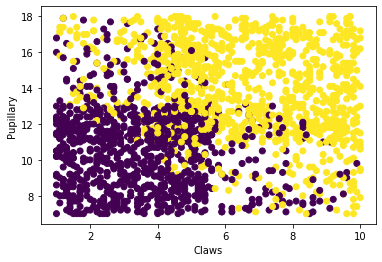

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(predictions["Front Claws"],predictions["Pupillary Distance"], c=predictions["prediction"])
ax.set_xlabel("Claws")
ax.set_ylabel("Pupillary")
plt.show()

In [44]:
count = 0
for index, row in predictions.iterrows():
    if row["Grizzly"] == row ["prediction"]:
        count +=1
        
print("Accuracy: {}%".format(count / len(predictions) * 100))

Accuracy: 83.55%
